# Linux baseline using random forest

We train a Random Forest classifier using patch features.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import arff
import math
import pandas as pd

from datetime import datetime as dt
from scipy.stats import randint as sp_randint
from interank.linuxdata import LinuxData
from sklearn.model_selection import RandomizedSearchCV, ParameterSampler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score, log_loss, f1_score, roc_curve, auc

DATA_DIR = '../datasets/linux/'

## Load dataset

In [2]:
%%time

df = pd.read_csv(DATA_DIR + 'data.csv')

df[['patch_id', 'name', 'company', 'subsystem', 'year', 'month', 'week', 'day', 'date', 'accepted']].head()

CPU times: user 5.28 s, sys: 464 ms, total: 5.74 s
Wall time: 5.74 s


In [3]:
df.keys()

Index(['Unnamed: 0', 'index', 'patch_id', 'name', 'company', 'msg_exp',
       'c_chunk_exp', 'commit_exp', 'epoch', 'month', 'year', 'day', 'week',
       'nr_ccs', 'cc_one', 'msg_length', 'bug_fix', 'thr_volume', 'thr_part',
       'ch_volume', 'thr_time', 'ch_time', 'rel_quarter', 'ch_first',
       'thr_first', 'patch_set', 'rev_nr', 'perc_in', 'chunks_in',
       'chunks_out', 'lkml_first', 'ch_lkml_first', 'subsystem',
       'spread_subsys', 'spread', 'size', 'accepted', 'missed', 'committer',
       'rev_one', 'cc_is_rev', 'main_time', 'linus_time', 'release_time',
       'total_time', 'right_venue', 'commit_sub', 'nr_commits', 'nth_try',
       'cc_is_rev1', 'main_period', 'linus_period', 'release_period',
       'total_period', 'nr_reviewers', 'nr_reviews', 'review_time',
       'response_time', 'first_response_time', 'thread_accepted',
       'first_patch', 'nr_pre_patch_messages', 'patch_set_id', 'last_msg_date',
       'date', 'accepted_rate_subsystem', 'accepted_rate_user

In [4]:
features = [
    # 'name',           # User name
    # 'company',        # User company
    # 'subsystem',      # Patched subsystem
    'msg_exp',        # Number of patches sent by user earlier
    'commit_exp',     # Number of accepted commit by user earlier
    'nr_ccs',         # Number of people CCed in email
    'msg_length',     # Number of lines of email excluding patch
    'bug_fix',        # Whether it is a bug fix (heuristics finding "bug" and/or "fix")
    'thr_volume',     # Number of emails in thread until patch
    'thr_part',       # Numer of people in thread until patch
    'rel_quarter',    # Quarter of release window in which patch is submitted
    'thr_first',      # Whether this email is the first of the thread
    'patch_set',      # Whether this patch is part of larger set
    'lkml_first',     # Whether the first email was sent to the Linux Kernel Mailing List
    'spread_subsys',  # Number of subsystems changed by patch
    'spread',         # Number of files changed by patch
    'size',           # Patch churn (number of added lines + number of deleted lines)
    'right_venue',    # Whether the patch is sent to the most adequate mailing list
    'commit_sub',     # Number of previously accepted patches modifying the subsystem
    'nth_try',        # Version of the patch (relative to thread)
    'first_patch'     # First patch in thread
]

# To be defined, not clear what these are
tbd = [
    'ch_volume',              # Int, 
    'cc_one',                 # String, first person in CC
    'thr_time',               # Int, seems to be equal to ch_time
    'ch_time',                # Int, seems to be equal to thr_time
    'ch_first',               # {yes, no}, seems to be equal to rev_one
    'rev_one',                # {1, 0}, seems to be equal to ch_first
    'rev_nr',                 # {1, 0}, number of reviews
    'ch_lkml_first',          # {yes, no}, 
    'main_time',              # Int or -1, 
    'linus_time',             # Int or -1, 
    'release_time',           # Int, time the patch is released?
    'nr_commits',             # Int, number of commits required to integrate the patch?
    'main_period',            # {within_hour, instantly, within_week, within_quarter}, 
    'thread_accepted',        # {yes, no}
    'nr_pre_patch_messages',  # Int, NOT the same as thr_volume
    'c_chunk_exp',            # Int, 
    'accepted'
]

In [5]:
df[tbd].sample(10)

,ch_volume,cc_one,thr_time,ch_time,ch_first,rev_one,rev_nr,ch_lkml_first,main_time,linus_time,release_time,nr_commits,main_period,thread_accepted,nr_pre_patch_messages,c_chunk_exp,accepted
524394,2.0,pelle@debian.org,0.0,0.0,yes,0.0,1.0,yes,-1.0,-1.0,1.281473e+09,0.0,instantly,yes,1.0,11.0,0
155285,36.0,ron.rindjunsky@intel.com,24.0,24.0,no,1.0,1.0,no,469515.0,4081385.0,6.995790e+06,1.0,within_week,yes,1.0,267.0,1
45695,5.0,linux-omap-open-source@linux.omap.com,539357.0,539357.0,yes,0.0,1.0,yes,-1.0,-1.0,1.281473e+09,0.0,instantly,no,3.0,300.0,0
376778,3.0,ath5k-devel@venema.h4ckr.net,40.0,40.0,no,0.0,1.0,no,-1.0,-1.0,1.281473e+09,0.0,instantly,no,0.0,0.0,0
120901,10.0,bbpetkov@yahoo.de,1.0,1.0,no,1.0,1.0,no,1723100.0,7343.0,6.417183e+06,1.0,within_month,yes,1.0,30.0,1
299500,0.0,stable@kernel.org,0.0,0.0,no,0.0,1.0,no,-1.0,-1.0,1.281473e+09,0.0,instantly,no,0.0,2611.0,0
348294,9.0,Jacob.Tanenbaum@logicpd.com,3.0,3.0,no,0.0,1.0,no,-1.0,-1.0,1.281473e+09,0.0,instantly,no,0.0,0.0,0
172946,0.0,joerg.roedel@amd.com,2.0,2.0,yes,0.0,1.0,yes,-1.0,-1.0,1.281473e+09,0.0,instantly,no,0.0,192.0,0
88750,0.0,mark@mtfhpc.demon.co.uk,0.0,0.0,no,1.0,1.0,no,59525.0,550629.0,5.515556e+06,1.0,within_day,no,0.0,3085.0,1
447569,27.0,Larry.Finger@gmail.com,86943.0,86943.0,no,1.0,1.0,no,3241721.0,5435443.0,6.088345e+06,3.0,within_quarter,yes,1.0,941.0,1


## Preprocess data

All entries in the data frame are strings, so we cast integers to `int` and floats to `float`. We also dummy encode categorical variables with one-hot vectors.

In [6]:
X = pd.DataFrame()

one_hot = OneHotEncoder()

for f in features:
    col = df[f]
    print('Processing column {}'.format(col.name))
    try:
        x = col.astype(int)
        X[col.name] = x
    except ValueError:
        try:
            x = col.astype(float)
            X[col.name] = x
        except ValueError:
            try:
                x = col.astype(str)
                if x[0] == 'yes' or x[0] == 'no':
                    x = x.map(lambda k: 1 if k == 'yes' else 0)
                    X[col.name] = x
                else:  # We use one-hot encoding
                    x = pd.get_dummies(x)
                    X = pd.concat([X, x], axis=1)
            except ValueError:
                print('Unknown type {}'.format(col[0]))
                
y = df['accepted']
X.head()

Processing column msg_exp
Processing column commit_exp
Processing column nr_ccs
Processing column msg_length
Processing column bug_fix
Processing column thr_volume
Processing column thr_part
Processing column rel_quarter
Processing column thr_first
Processing column patch_set
Processing column lkml_first
Processing column spread_subsys
Processing column spread
Processing column size
Processing column right_venue
Processing column commit_sub
Processing column nth_try
Processing column first_patch


,msg_exp,commit_exp,nr_ccs,msg_length,bug_fix,thr_volume,thr_part,q1,q2,q3,...,thr_first,patch_set,lkml_first,spread_subsys,spread,size,right_venue,commit_sub,nth_try,first_patch
0,1319,0,2,62,0,5,3,1,0,0,...,1,0,1,7,10,167,1,0,1,1
1,0,0,4,14,0,4,1,1,0,0,...,1,0,1,1,1,2,1,0,1,1
2,216,0,2,20,0,0,0,1,0,0,...,1,0,1,1,2,4,1,0,1,1
3,77,0,2,23,0,0,0,1,0,0,...,1,0,1,1,1,4,1,0,1,1
4,0,0,1,4,1,2,1,1,0,0,...,1,0,1,1,1,4,0,0,1,1


## Split dataset

Split the dataset into 80% for training and 20% for testing.

In [7]:
# Define split size
threshold = 0.8
train_idx = math.ceil(len(y) * 0.8)

# Split into train and test sets
X_train = X.iloc[:train_idx, :]
X_test = X.iloc[train_idx:, :]
y_train = y.iloc[:train_idx].squeeze()
y_test = y.iloc[train_idx:].squeeze()

print('Train set: {} patches'.format(len(X_train)))
print('Test set: {} patches'.format(len(X_test)))

Train set: 495536 patches
Test set: 123883 patches


## Tune hyperparameters

We use randomized search to tune the hyperparameters. The idea is to define some distribution for each hyperparameter and then sample from them `n` times.

It takes about 30 minutes for `n = 50`.

In [ ]:
%%time

# Define the parameters sitributions
param_dist = {"n_estimators": [8, 16, 32, 64, 128],
              "max_depth": [3, None],
              "max_features": sp_randint(1, 11),
              "min_samples_split": sp_randint(2, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}


def evaluate(params):
    '''Evaluate a random forest for a given hyperparameters.'''
    result = dict()
    
    rf = RandomForestClassifier(**params,
                                random_state=0,
                                class_weight='balanced')
    
    rf.fit(X_train, y_train, sample_weight=None)
    
    probs = rf.predict_proba(X_test)
    predictions = probs[:, 1]
    
    result['probs'] = probs
    result['avg_log_loss'] = log_loss(y_test, predictions)
    result['auc'] = average_precision_score(y_test, predictions)
    result['params'] = params
    
    return result
    

# Sample 50 different combinations
n_iter = 50
params_list = list(ParameterSampler(param_dist, n_iter=n_iter))

results = list()
for i, params in enumerate(params_list):
    result = evaluate(params)
    print('Model {}: log-loss = {:.6f}, AUC = {:.4f}'
          .format(i + 1, result['avg_log_loss'], result['auc']))
    results.append(result)

In [51]:
# for result in results: 
#     print('Iteration {}: log-loss = {:.6f}, AUC = {:.4f}'
#           .format(i + 1, result['avg_log_loss'], result['auc']))

best_log_loss = sorted(results, key=lambda k: k['avg_log_loss'])[0]
best_auc = sorted(results, key=lambda k: k['auc'])[-1]

print('Best model (log-loss): log-loss = {}, AUC = {}\n    {}'
      .format(best_log_loss['avg_log_loss'], 
              best_log_loss['auc'], 
              best_log_loss['params']))
print('Best model (AUC): log-loss = {}, AUC = {}\n    {}'
      .format(best_auc['avg_log_loss'], 
              best_auc['auc'], 
              best_auc['params']))

Best model (log-loss): log-loss = 0.5982518085114312, AUC = 0.50398916056482
    {'max_features': 2, 'n_estimators': 64, 'min_samples_split': 6, 'criterion': 'gini', 'max_depth': None, 'bootstrap': False, 'min_samples_leaf': 1}
Best model (AUC): log-loss = 0.6067273349152144, AUC = 0.5265224495203715
    {'max_features': 5, 'n_estimators': 128, 'min_samples_split': 3, 'criterion': 'entropy', 'max_depth': None, 'bootstrap': False, 'min_samples_leaf': 6}


## Test model with best hyperparameters

We use the best hyperparameters obtained from the above cells.

In [8]:
%%time

# Obtained by randomized search
params = {
    'max_features': 2, 
    'n_estimators': 64, 
    'min_samples_split': 6, 
    'criterion': 'gini', 
    'max_depth': None, 
    'bootstrap': False, 
    'min_samples_leaf': 1
}

rf = RandomForestClassifier(**params,
                            random_state=0,
                            class_weight='balanced')
rf = rf.fit(X_train, y_train, sample_weight=None)

CPU times: user 49.3 s, sys: 572 ms, total: 49.9 s
Wall time: 49.9 s


Log-loss: 0.599121334477688
AUC: 0.5045597388838335
F1-score: 0.49323151683443245


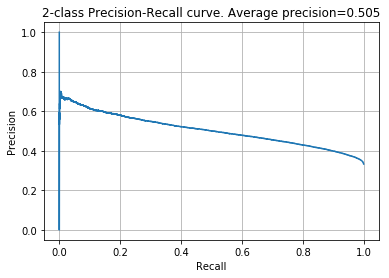

In [9]:
probs = rf.predict_proba(X_test)
predictions = probs[:, 1]

average_precision = average_precision_score(y_test, predictions)

print('Log-loss: {}'.format(log_loss(y_test, predictions)))
print('AUC: {}'.format(average_precision))
print('F1-score: {}'.format(f1_score(y_test, [p > 0.5 for p in predictions])))

precision, recall, _ = precision_recall_curve(y_test, predictions)

plt.plot(recall, precision)

plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve. Average precision={0:0.3f}'.format(average_precision))
plt.show()

/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


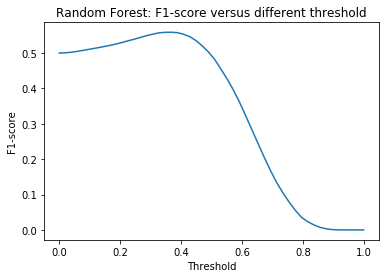

In [10]:
x = np.linspace(0, 1, 50)
y = [f1_score(y_test, [p > t for p in predictions]) for t in x]

plt.plot(x, y)
plt.ylabel('F1-score')
plt.xlabel('Threshold')
plt.title('Random Forest: F1-score versus different threshold')
plt.show()

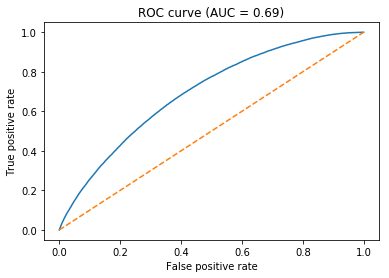

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.title('ROC curve (AUC = %0.2f)' % roc_auc)
plt.show()

In [12]:
with open('../data/linux-baseline-ml-probs.txt', 'w') as f:
    f.writelines(['{:.20f}\n'.format(p) for p in predictions])